In [33]:
import pandas as pd 
import numpy as np 
from utils import * 
from src import get_genome_id
import os
from src.files import FASTAFile, InterProScanFile
import subprocess
import glob
import seaborn as sns 
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
ref_df = load_ref(add_labels=True)

In [58]:
ref_df[(ref_df.label == 'spurious')].category.unique()

array(['conflict'], dtype=object)

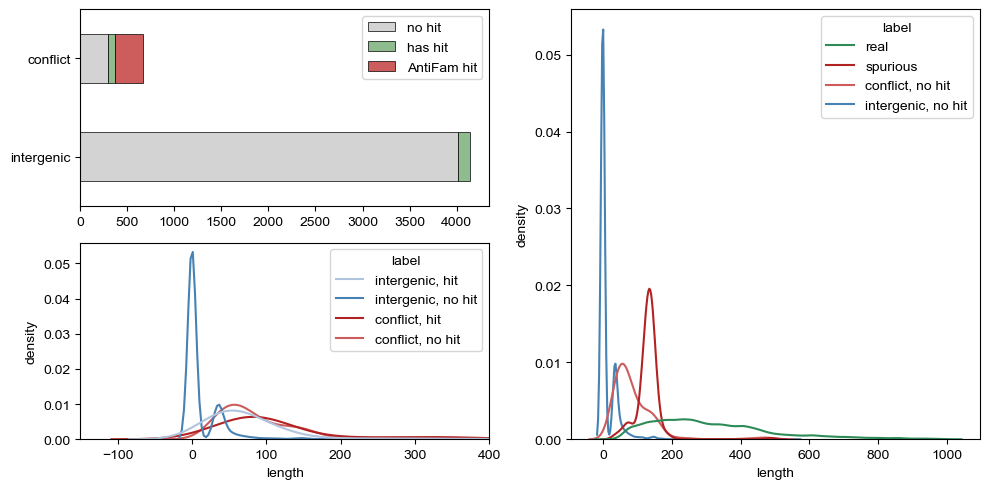

In [74]:
def figure_1(ref_df:pd.DataFrame, max_length:int=1000):
    ref_df = ref_df[ref_df.reason != 'suspect top hit'].copy()
    ref_df = ref_df[ref_df.query_length // 3 < max_length].copy()

    fig = plt.figure(figsize=(10, 5), layout='tight')
    grid = GridSpec(figure=fig, nrows=2, ncols=2)
    ax_a = fig.add_subplot(grid[0, 0])
    ax_b = fig.add_subplot(grid[1, 0])
    ax_c = fig.add_subplot(grid[:, 1])

    ax_a_df = pd.DataFrame(columns=['no hit', 'has hit', 'AntiFam hit'], index=['intergenic', 'conflict'])
    for category in ['intergenic', 'conflict']:
        ax_a_df.loc[category, 'AntiFam hit'] = ((ref_df.reason == 'AntiFam InterProScan hit') & (ref_df.category == category)).sum()
        ax_a_df.loc[category, 'no hit'] = ((ref_df.reason == 'no InterProScan hit') & (ref_df.category == category)).sum()
        ax_a_df.loc[category, 'has hit'] = ((ref_df.reason == 'needs manual validation') & (ref_df.category == category)).sum()
    ax_a_df.plot(kind='barh', stacked=True, color=['lightgray', 'darkseagreen', 'indianred'], ax=ax_a, edgecolor='black', linewidth=0.5)

    ax_b_df = ref_df[ref_df.category.isin(['conflict', 'intergenic'])][['query_length', 'reason', 'category']].copy()
    conditions = [(ax_b_df.reason == 'needs manual validation') & (ax_b_df.category == 'intergenic'), (ax_b_df.reason == 'no InterProScan hit') & (ax_b_df.category == 'intergenic')]
    conditions += [(ax_b_df.reason == 'needs manual validation') & (ax_b_df.category == 'conflict'), (ax_b_df.reason == 'no InterProScan hit') & (ax_b_df.category == 'conflict')]
    # conditions += [(ax_b_df.reason == 'AntiFam InterProScan hit') & (ax_b_df.category == 'conflict')]
    labels = ['intergenic, hit', 'intergenic, no hit', 'conflict, hit', 'conflict, no hit']
    ax_b_df['label'] = np.select(conditions, labels, default=None)
    ax_b_df = ax_b_df.rename(columns={'query_length':'length'})
    ax_b_df.length = ax_b_df.length // 3
    colors = ['lightsteelblue', 'steelblue', 'firebrick', 'indianred']
    # linestyles = ['solid', 'dotted', 'solid', 'dotted', 'solid']
    sns.kdeplot(data=ax_b_df, hue='label', x='length', ax=ax_b, palette=colors, hue_order=labels, common_norm=False)
    ax_b.set_xlim(xmax=400)
    ax_b.set_ylabel('density')

    ax_c_mask = ref_df.category.isin(['conflict', 'intergenic']) & ref_df.reason.isin(['no InterProScan hit', 'AntiFam InterProScan hit'])
    ax_c_mask = ax_c_mask | (ref_df.label == 'real')
    ax_c_df = ref_df[ax_c_mask][['label', 'query_length', 'category']].copy()
    ax_c_df = ax_c_df.rename(columns={'query_length':'length'})
    ax_c_df.length = ax_c_df.length // 3
    ax_c_df.loc[(ax_c_df.category == 'conflict') & (ax_c_df.label == 'none'), 'label'] = 'conflict, no hit'
    ax_c_df.loc[(ax_c_df.category == 'intergenic') & (ax_c_df.label == 'none'), 'label'] = 'intergenic, no hit'
    colors = ['seagreen', 'firebrick', 'indianred', 'steelblue']
    hue_order = ['real', 'spurious', 'conflict, no hit', 'intergenic, no hit']
    sns.kdeplot(data=ax_c_df, hue='label', x='length', ax=ax_c, palette=colors, hue_order=hue_order, common_norm=False)
    ax_c.set_ylabel('density')

    plt.show()

figure_1(ref_df)